# Tarefa 1 - Classificador e Regressor
## Importar Bibliotecas

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

O data set é gerado direto pelo arquivo gerar_dados_vitimas.py disponibilizado pelo professor (único parâmetro alterado foi o número de vítimas)

In [15]:
df_treino = pd.read_csv('datasets/vict/10v/data.csv')
print(f"Dataset com {len(df_treino)} vítimas")
print(df_treino.head())
X = df_treino.iloc[:, 0:10].values   # colunas 1 a 10
y = df_treino["sobr"].values          # coluna 13

Dataset com 800 vítimas
   idade   fc  fr  pas  spo2       temp  pr  sg  fx  queim  gcs  avpu  tri  \
0     21    0   0    0    17  26.291506   0   3   0      0    3     3    3   
1     21  109  25   96    93  37.353475   1   1   0      0   13     1    1   
2     30  102  26   96    92  37.708092   0   1   1      0   13     0    1   
3     18    2   0    0    37  27.775682   0   3   0      3    3     3    3   
4     23   95  18  114    98  36.894670   1   0   1      0   15     0    0   

   sobr  
0  0.22  
1  0.92  
2  0.86  
3  0.24  
4  0.98  


## Divisão de Dataset de Treino (75%) e Teste(25%)

In [16]:
## Dividir o dataset em treinamento/validação e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, shuffle=True)
print(f"Tamanho total do dataset: {len(X)}\n")
print(f"Dados de treinamento X ({len(X_treino)}):\n{X_treino[:3]} ...")
print(f"Dados de treinamento y:({len(y_treino)})\n {y_treino[:3]} ...")
print("---")
print(f"Dados de teste   X ({len(X_teste)}):\n{X_teste[:3]} ...")
print(f"Dados de teste   y:({len(y_teste)})\n {y_teste[:3]} ...")

Tamanho total do dataset: 800

Dados de treinamento X (600):
[[ 31.         125.          37.          72.          86.
   34.313266     0.           3.           1.           0.        ]
 [ 24.         112.          20.         100.          90.
   36.87119948   0.           1.           1.           0.        ]
 [ 26.         140.          34.          77.          87.
   34.18309226   0.           3.           1.           0.        ]] ...
Dados de treinamento y:(600)
 [0.67 0.79 0.6 ] ...
---
Dados de teste   X (200):
[[ 26.          78.          19.         123.         100.
   37.13474992   1.           0.           1.           0.        ]
 [ 23.          95.          12.         118.          94.
   37.55386752   1.           0.           1.           0.        ]
 [ 23.         146.          32.          83.          88.
   34.15818533   0.           3.           1.           2.        ]] ...
Dados de teste   y:(200)
 [0.93 0.99 0.19] ...


## Parametrização

In [17]:
# parametros variaveis
num_params = 3               # num de parametrizacoes a treinar
n_layers = [2, 6, 30]
n_neurons = [2, 10, 30]
learning_rates = [0.01, 0.025, 0.035]

# n_layers = [2, 6, 20]
# n_neurons = [4, 10, 20]
# learning_rates = [0.01, 0.025, 0.03]

# parametros fixos
solver = 'sgd'
max_iter = 10000
activation = 'tanh'
momentum = 0.95

results = []

# validação cruzada
k_folds = 5

## Treino dos modelos

In [18]:
# Vars para salvar os modelos e resultados
best_model=[]   # armazenar o melhor modelo de cada parametrização
model=[]        # todos os modelos de cada parametrização
train_scores=[]
vld_scores=[]
best_index=[]
mse=[]

# Instanciação do regressor i
for i in range(num_params):
  # Correctly create a tuple for hidden_layer_sizes
  neurons_per_layer = tuple([n_neurons[i]] * n_layers[i])

  print(f"training MLP with hidden layers: {neurons_per_layer}")
  rn = MLPRegressor(
      hidden_layer_sizes=neurons_per_layer,
      activation=activation,
      solver=solver,
      learning_rate='adaptive',
      learning_rate_init=learning_rates[i],
      max_iter=max_iter,
      shuffle=True,
      momentum=momentum,
      random_state=42
      )

  # cross_validate faz fit (treinamento) e retorna um modelo aprendido por fold,
  # o score de treino e o de validação (ver mais abaixo)
  cv_results = cross_validate(
      rn,
      X_treino,
      y_treino,
      cv=k_folds,
      scoring='neg_mean_squared_error', # scikit usa negativo para manter o padrao de quanto mais alto o score, melhor o estimador
                                        # Neste caso, quanto maior o MSE (negativo), melhor será porque mede o erro.
      return_train_score=True,  # Include training scores
      return_estimator=True     # Include trained models
  )

  # MSE de treino e validação (erro quadrático médio, mean squared error)
  train_scores.append(cv_results['train_score'])
  vld_scores.append(cv_results['test_score'])
  print(f"NEG MSE treino   : {train_scores[i]}")
  print(f"NEG MSE validação: {vld_scores[i]}\n")

  # Diferença absoluta do MSE do treinamento e de validação
  bias = np.abs(train_scores[i] - vld_scores[i])

  # Salva o indice do menor score)
  best_index.append(np.argmax(vld_scores[i]))

  # Salva o modelo que apresenta melhor score (MSE)
  best_model.append(cv_results['estimator'][best_index[i]])

  # Salva todos os modelos da parametrizacao
  model.append(cv_results['estimator'])

  #print(f"Parametrization {i+1}: {model}")
  print(f"Best Index: {best_index[i]}\n")

training MLP with hidden layers: (2, 2)
NEG MSE treino   : [-0.11972565 -0.11673094 -0.11644877 -0.11474181 -0.11849399]
NEG MSE validação: [-0.10718814 -0.11946505 -0.12030471 -0.13046095 -0.11395082]

Best Index: 0

training MLP with hidden layers: (10, 10, 10, 10, 10, 10)
NEG MSE treino   : [-0.01333432 -0.01249732 -0.01321724 -0.01308225 -0.01295327]
NEG MSE validação: [-0.01114473 -0.01525808 -0.01563658 -0.01198803 -0.01450839]

Best Index: 0

training MLP with hidden layers: (30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30)
NEG MSE treino   : [-0.04570774 -0.04237249 -0.04437637 -0.04569756 -0.04099813]
NEG MSE validação: [-0.03588158 -0.04983944 -0.04271881 -0.03689939 -0.05559294]

Best Index: 0



## Métricas

In [19]:
print("Train & Valid Scores (Neg MSE) per parametrization:")
for i in range(num_params):
  print(f"Par{i+1}\tMean\t\tVar.\t\tScores per fold")
  # ddof=1 variancia amostral
  print(f"Trn:\t{train_scores[i].mean():>8.6f}\t{train_scores[i].var(ddof=1):>8.6f}\t{train_scores[i]}")
  print(f"Vld:\t{vld_scores[i].mean():>8.6f}\t{vld_scores[i].var(ddof=1):>8.6f}\t{vld_scores[i]}")
  print(f"Dif:\t{np.abs(train_scores[i].mean() - vld_scores[i].mean()):>8.6f}\t\t\t{abs(train_scores[i] - vld_scores[i])}")
  print(f"Best index: {best_index[i]}")
  print()

Train & Valid Scores (Neg MSE) per parametrization:
Par1	Mean		Var.		Scores per fold
Trn:	-0.117228	0.000004	[-0.11972565 -0.11673094 -0.11644877 -0.11474181 -0.11849399]
Vld:	-0.118274	0.000074	[-0.10718814 -0.11946505 -0.12030471 -0.13046095 -0.11395082]
Dif:	0.001046			[0.0125375  0.00273411 0.00385594 0.01571914 0.00454317]
Best index: 0

Par2	Mean		Var.		Scores per fold
Trn:	-0.013017	0.000000	[-0.01333432 -0.01249732 -0.01321724 -0.01308225 -0.01295327]
Vld:	-0.013707	0.000004	[-0.01114473 -0.01525808 -0.01563658 -0.01198803 -0.01450839]
Dif:	0.000690			[0.00218959 0.00276075 0.00241933 0.00109422 0.00155512]
Best index: 0

Par3	Mean		Var.		Scores per fold
Trn:	-0.043830	0.000004	[-0.04570774 -0.04237249 -0.04437637 -0.04569756 -0.04099813]
Vld:	-0.044186	0.000072	[-0.03588158 -0.04983944 -0.04271881 -0.03689939 -0.05559294]
Dif:	0.000356			[0.00982616 0.00746695 0.00165756 0.00879817 0.01459481]
Best index: 0



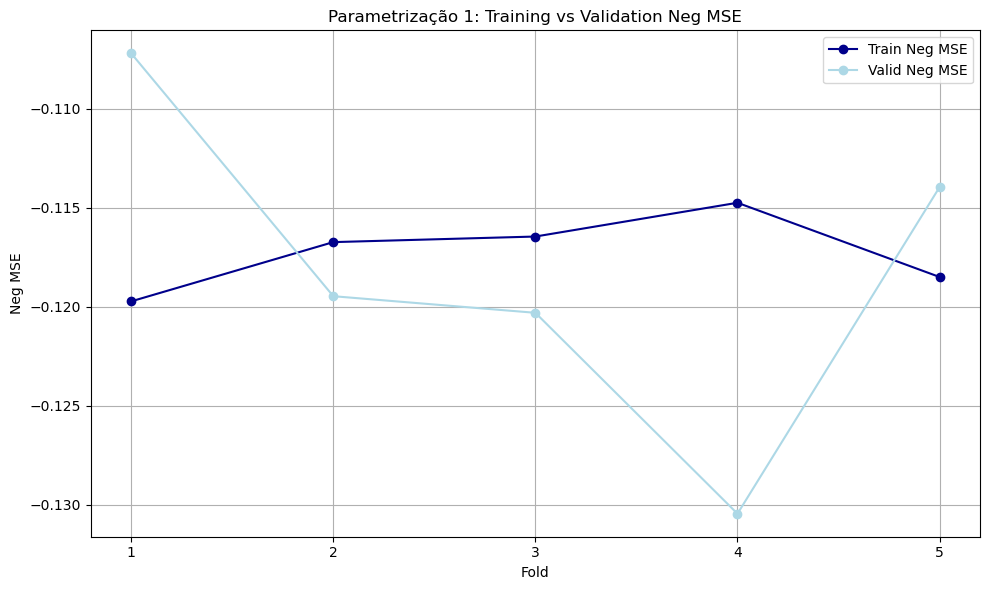

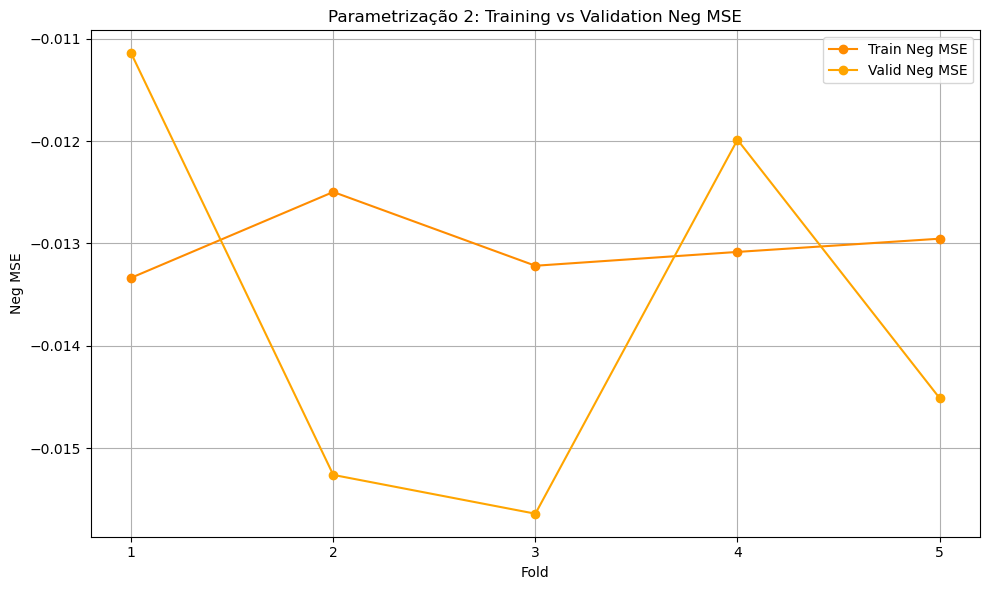

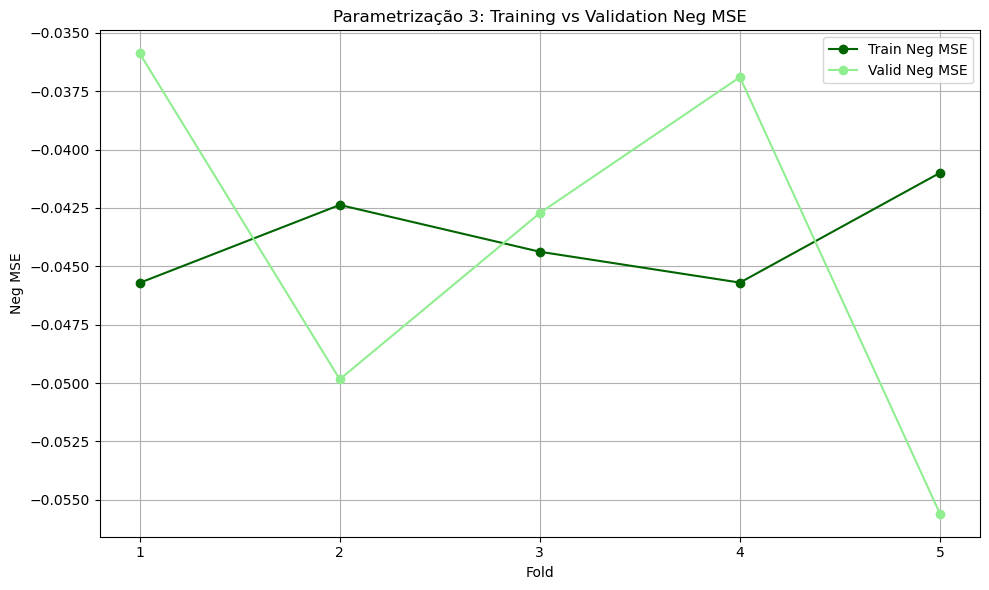

In [20]:
colors = [
    ["darkblue", "lightblue"],  # Tons de azul para i=0
    ["darkorange", "orange"],  # Tons de laranja para i=1
    ["darkgreen", "lightgreen"],  # Tons de verde para i=2 (se houver mais índices)
]

for i in range(3):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_scores[i]) + 1), train_scores[i], label=f"Train Neg MSE", marker='o', color=colors[i][0])
    plt.plot(range(1, len(vld_scores[i]) + 1), vld_scores[i], label=f"Valid Neg MSE", marker='o', color=colors[i][1])
    plt.xlabel("Fold")
    plt.ylabel("Neg MSE")
    plt.title(f"Parametrização {i+1}: Training vs Validation Neg MSE")
    plt.legend()
    plt.xticks(np.arange(1, k_folds + 1, 1))
    plt.grid()
    plt.tight_layout()
    plt.show()


## Retreinar o modelo

In [21]:
# parametros variaveis
num_params = 1               # num de parametrizacoes a treinar
n_layers = [6]
n_neurons = [10]
learning_rates = [0.025]

results = []

# Vars para salvar os modelos e resultados
best_model=[]   # armazenar o melhor modelo de cada parametrização
model=[]        # todos os modelos de cada parametrização
train_scores=[]
vld_scores=[]
best_index=[]
mse=[]

# Instanciação do regressor i
# Correctly create a tuple for hidden_layer_sizes
neurons_per_layer = tuple([n_neurons[0]] * n_layers[0])

print(f"training MLP with hidden layers: {neurons_per_layer}")
rn = MLPRegressor(
    hidden_layer_sizes=neurons_per_layer,
    activation=activation,
    solver=solver,
    learning_rate='adaptive',
    learning_rate_init=learning_rates[0],
    max_iter=max_iter,
    shuffle=True,
    momentum=momentum,
    random_state=42
    )

# cross_validate faz fit (treinamento) e retorna um modelo aprendido por fold,
# o score de treino e o de validação (ver mais abaixo)
cv_results = cross_validate(
    rn,
    X,
    y,
    cv=k_folds,
    scoring='neg_mean_squared_error', # scikit usa negativo para manter o padrao de quanto mais alto o score, melhor o estimador
                                      # Neste caso, quanto maior o MSE (negativo), melhor será porque mede o erro.
    return_train_score=True,  # Include training scores
   return_estimator=True     # Include trained models
)

# MSE de treino e validação (erro quadrático médio, mean squared error)
train_scores.append(cv_results['train_score'])
vld_scores.append(cv_results['test_score'])
print(f"NEG MSE treino   : {train_scores[0]}")
print(f"NEG MSE validação: {vld_scores[0]}\n")

# Diferença absoluta do MSE do treinamento e de validação
bias = np.abs(train_scores[0] - vld_scores[0])

# Salva o indice do menor score)
best_index.append(np.argmax(vld_scores[0]))
best_model.append(cv_results['estimator'][best_index[0]])

#print(f"Parametrization {i+1}: {model}")
print(f"Best Index: {best_index[0]}\n")

training MLP with hidden layers: (10, 10, 10, 10, 10, 10)
NEG MSE treino   : [-0.01325567 -0.01276369 -0.01233665 -0.01227535 -0.01162572]
NEG MSE validação: [-0.01090842 -0.01279871 -0.01297103 -0.01346624 -0.01556968]

Best Index: 0



In [22]:
print("Train & Valid Scores (Neg MSE) per parametrization:")
print(f"Par{1}\tMean\t\tVar.\t\tScores per fold")
# ddof=1 variancia amostral
print(f"Trn:\t{train_scores[0].mean():>8.6f}\t{train_scores[0].var(ddof=1):>8.6f}\t{train_scores[0]}")
print(f"Vld:\t{vld_scores[0].mean():>8.6f}\t{vld_scores[0].var(ddof=1):>8.6f}\t{vld_scores[0]}")
print(f"Dif:\t{np.abs(train_scores[0].mean() - vld_scores[0].mean()):>8.6f}\t\t\t{abs(train_scores[0] - vld_scores[0])}")
print(f"Best index: {best_index[0]}")
print()

Train & Valid Scores (Neg MSE) per parametrization:
Par1	Mean		Var.		Scores per fold
Trn:	-0.012451	0.000000	[-0.01325567 -0.01276369 -0.01233665 -0.01227535 -0.01162572]
Vld:	-0.013143	0.000003	[-0.01090842 -0.01279871 -0.01297103 -0.01346624 -0.01556968]
Dif:	0.000691			[2.34724650e-03 3.50135118e-05 6.34381533e-04 1.19089155e-03
 3.94396230e-03]
Best index: 0



## Teste de predição

In [23]:
df_pred = pd.read_csv('datasets/vict/10v/dataprediction.csv')
print(f"Dataset com {len(df_pred)} vítimas")
print(df_pred.head())
X_pred = df_pred.iloc[:, 0:10].values   # colunas 1 a 10
y_pred = cv_results['estimator'][0].predict(X_pred)
y_true_pred = df_pred["sobr"].values          # coluna 13

from sklearn.metrics import mean_absolute_error

# Calcular métricas de regressão
mae = mean_absolute_error(y_true_pred, y_pred)

# Exibir os resultados
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")

Dataset com 1000 vítimas
   idade   fc  fr  pas  spo2       temp  pr  sg  fx  queim  gcs  avpu  tri  \
0      2  105  26   99    98  37.249129   1   1   0      0   12     1    1   
1     46   11   3    3    29  28.146728   0   3   0      3    5     3    3   
2     59  106  29  115    98  38.073368   1   1   0      0   12     1    1   
3     24  158  41   64    78  35.314096   0   3   1      0   10     2    2   
4     32   11   1    0    65  32.876004   0   3   1      3    4     3    3   

   sobr  
0  0.70  
1  0.28  
2  0.74  
3  0.75  
4  0.10  
Erro Absoluto Médio (MAE): 0.18


In [24]:
from sklearn.metrics import mean_squared_error

neg_mse_pred = -mean_squared_error(y_true_pred, y_pred)

print(f"Negativo do MSE da predição: {neg_mse_pred:.6f}")

Negativo do MSE da predição: -0.068369


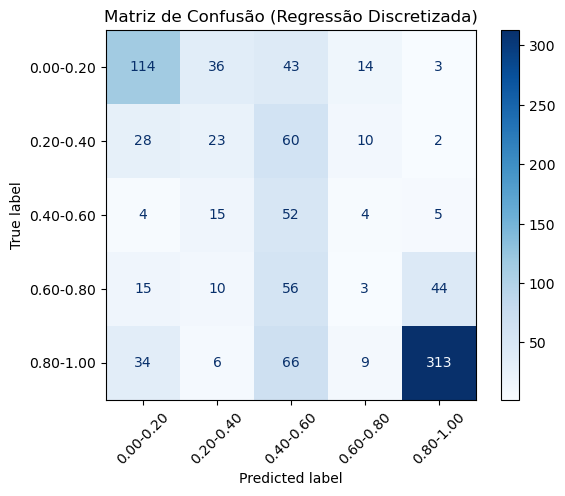

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Definir os bins (faixas)
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]

# Discretizar os valores reais e previstos, garantindo que sejam floats
y_true_binned = pd.cut(np.array(y_true_pred, dtype=float), bins=bins, labels=labels, include_lowest=True)
y_pred_binned = pd.cut(np.array(y_pred, dtype=float), bins=bins, labels=labels, include_lowest=True)

# Converter para strings para garantir consistência
y_true_binned = y_true_binned.astype(str)
y_pred_binned = y_pred_binned.astype(str)

# Calcular matriz de confusão
cm = confusion_matrix(y_true_binned, y_pred_binned, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão (Regressão Discretizada)")
plt.show()

In [26]:
import joblib

best_param_idx = np.argmax([np.mean(scores) for scores in vld_scores])
print(f"Melhor parametrização: {best_param_idx + 1}")

best_overall_model = best_model[best_param_idx]

import joblib
joblib.dump(best_overall_model, 'models/regressor_model.pkl')
print("Modelo exportado como 'models/regressor_model.pkl'")

Melhor parametrização: 1
Modelo exportado como 'models/regressor_model.pkl'
